In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np
from random import randint

plt.style.use(["Solarize_Light2"])
plt.rcParams["axes.edgecolor"] = "#66818c"
plt.rcParams["axes.facecolor"] = "#263238"
plt.rcParams["figure.facecolor"] = "#263238"
plt.rcParams["grid.color"] = "#3f575b"
plt.rcParams["xtick.color"] = "#bfd5dd"
plt.rcParams["ytick.color"] = "#bfd5dd"
plt.rcParams["text.color"] = "#bfd5dd"
plt.rcParams["axes.labelcolor"] = "#bfd5dd"

engine = create_engine("postgresql+psycopg2://{}:{}@{}:{}/{}".format())
table_name = "flat"

In [12]:
query = """ SELECT area,
                   price,
                   lng,
                   lat,
                   building_id
            FROM flat
            INNER JOIN building ON flat.building_id = building.id
            WHERE NOT lng IS NULL
            AND NOT lat IS NULL
        """
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df

area       price        lng        lat  building_id            ppm
0       71.4  34000000.0  37.549040  55.762247         2220  476190.476190
1       54.0   8700000.0  37.452651  55.591467            2  161111.111111
2       39.4   6177920.0  37.413718  55.617017            4  156800.000000
3       60.9   8900000.0  37.479510  55.569052            6  146141.215107
4       34.0   5550000.0  37.343829  55.518041            7  163235.294118
...      ...         ...        ...        ...          ...            ...
24581   73.0   6950000.0  37.304914  55.484520         1542   95205.479452
24582   65.0   8200000.0  37.666926  55.623437         8149  126153.846154
24583   80.0   9000000.0  37.297089  55.478516         8150  112500.000000
24584  100.0  11700000.0  37.384379  55.852192         1657  117000.000000
24585   49.0   4300000.0  37.151050  55.544346         1609   87755.102041

[24586 rows x 6 columns]

In [7]:
(df.ppm/100000).describe()

count    24586.000000
mean         4.721739
std        178.679432
min          0.233236
25%          1.630211
50%          1.989574
75%          2.722764
max      19000.000000
Name: ppm, dtype: float64

In [13]:
mppm = df.groupby("building_id").ppm.median().copy()

In [32]:
mppm[1]

198780.48780487804

In [10]:
plt.figure(figsize=(30, 10))
plt.scatter(df.ppm, df.d1, s=5);

AttributeError: 'DataFrame' object has no attribute 'ppm'

<Figure size 2160x720 with 0 Axes>

In [14]:
query = """ SELECT id,
                   lat,
                   lng
            FROM building
            WHERE district > -1
        """
df = pd.read_sql(query, engine)
for idx, item in df.iterrows():
    if int(item.id) in mppm.index:
        df.loc[idx, "mppm"] = mppm[item.id]
df = df[df.mppm < 2.785756e+06]

In [115]:
df.d1 < .7

2        True
4        True
5        True
7        True
9        True
         ... 
19362    True
19363    True
19366    True
19371    True
19380    True
Name: d1, Length: 7495, dtype: bool

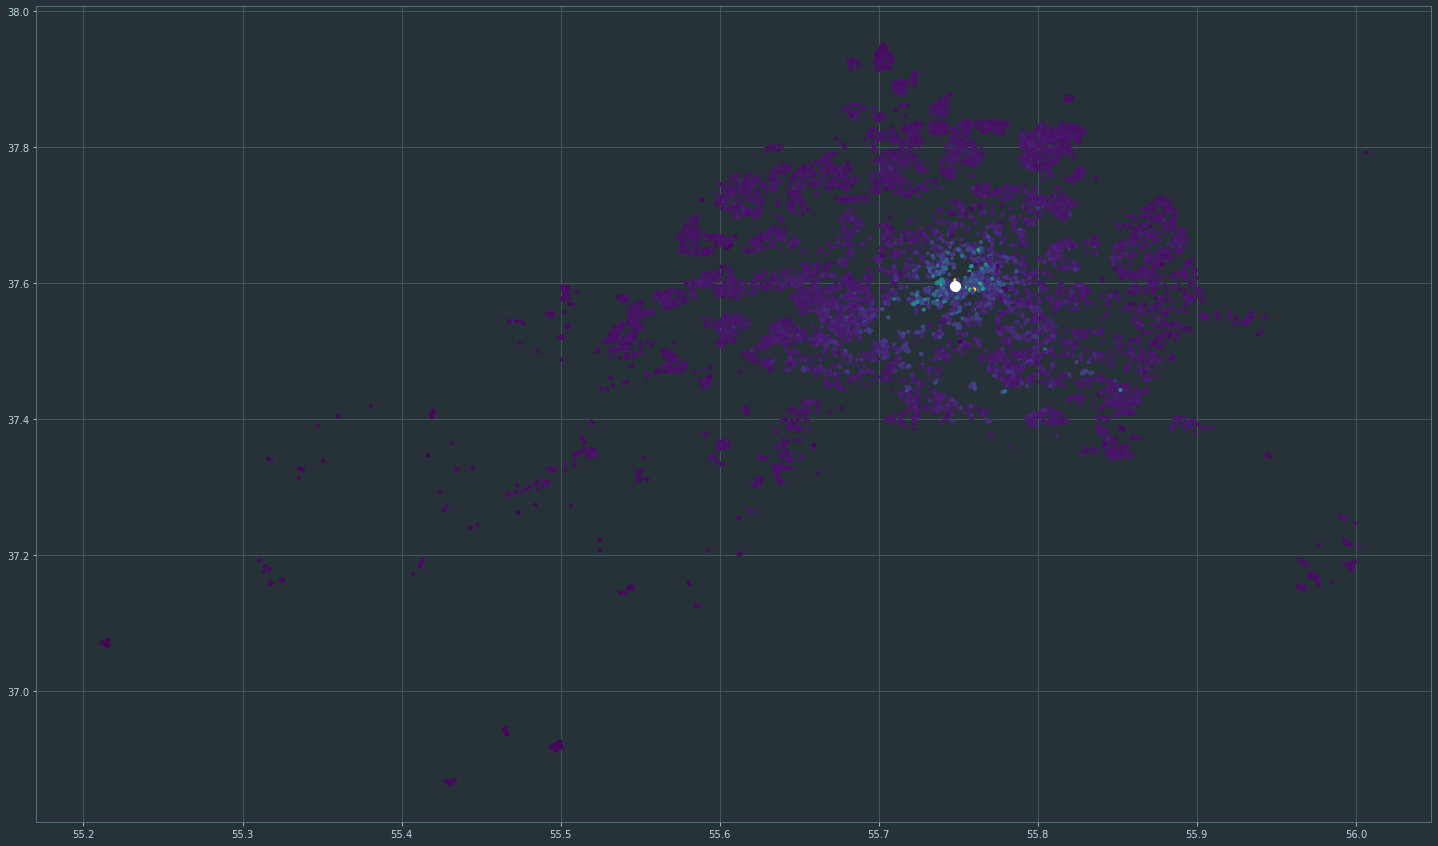

In [15]:
plt.figure(figsize=(25, 15))
plt.scatter(df.lat, df.lng, c=df.mppm/1000000, s=10);
plt.scatter(55.74813359000001, 37.59565428999999, s=100, c="w")

In [86]:
df[df.mppm < 2.785756e+06].sort_values("mppm").tail(100).lat.mean(),\
df[df.mppm < 2.785756e+06].sort_values("mppm").tail(100).lng.mean()

(55.74813359000001, 37.59565428999999)

In [139]:
table_name = "flat"
query = """ SELECT owner_type,
                   area,
                   area_kitchen,
                   area_living,
                   floor,
                   rooms,
                   layout,
                   height,
                   bathrooms,
                   window_types,
                   balconies,
                   condition,
                   price,
                   type,
                   year,
                   material,
                   floors,
                   garbage_chute,
                   heating_type,
                   district,
                   lng,
                   lat
            FROM {}
            INNER JOIN building ON flat.building_id = building.id
            WHERE district > -1
        """.format(table_name)
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df.drop("price", axis=True, inplace=True)
df.loc[:, "window_0"] = df.window_types.apply(lambda i: None if i is None else i[0])
df.loc[:, "window_1"] = df.window_types.apply(lambda i: None if i is None else i[1])
df[["window_1", "window_0"]] = df[["window_1", "window_0"]].fillna(0)
df.drop("window_types", axis=True, inplace=True)
df.loc[:, "bathrooms_0"] = df.bathrooms.apply(lambda i: None if i is None else i[0])
df.loc[:, "bathrooms_1"] = df.bathrooms.apply(lambda i: None if i is None else i[1])
df[["bathrooms_0", "bathrooms_1"]] = df[["bathrooms_0", "bathrooms_1"]].fillna(0)
df.drop("bathrooms", axis=True, inplace=True)
df.loc[:, "balconies_0"] = df.balconies.apply(lambda i: None if i is None else i[0])
df.loc[:, "balconies_1"] = df.balconies.apply(lambda i: None if i is None else i[1])
df[["balconies_0", "balconies_1"]] = df[["balconies_0", "balconies_1"]].fillna(0)
df.drop("balconies", axis=True, inplace=True)
df.loc[~df.garbage_chute.isnull() & df.garbage_chute, "garbage_chute_1"] = 1
df.loc[~df.garbage_chute.isnull() & df.garbage_chute == False, "garbage_chute_0"] = 1
df.loc[:, "garbage_chute_0"] = df.loc[:, "garbage_chute_0"].fillna(0)
df.loc[:, "garbage_chute_1"] = df.loc[:, "garbage_chute_1"].fillna(0)
df.drop("garbage_chute", axis=True, inplace=True)
for i in df.type.unique():
    if i >= .0:
        df.loc[df.type == i, "type_"+str(i)] = 1
        df.loc[:, "type_"+str(i)] = df.loc[:, "type_"+str(i)].fillna(0)
df.drop("type", axis=True, inplace=True)
for i in df.layout.unique():
    if i >= .0:
        df.loc[df.layout == i, "layout_"+str(i)] = 1
        df.loc[:, "layout_"+str(i)] = df.loc[:, "layout_"+str(i)].fillna(0)
df.drop("layout", axis=True, inplace=True)
for i in df.material.unique():
    if i >= .0:
        df.loc[df.material == i, "material_"+str(i)] = 1
        df.loc[:, "material_"+str(i)] = df.loc[:, "material_"+str(i)].fillna(0)
df.drop("material", axis=True, inplace=True)
for i in df.condition.unique():
    if i >= .0:
        df.loc[df.condition == i, "condition_"+str(i)] = 1
        df.loc[:, "condition_"+str(i)] = df.loc[:, "condition_"+str(i)].fillna(0)
df.drop("condition", axis=True, inplace=True)
for i in df.heating_type.unique():
    if i >= .0:
        df.loc[df.heating_type == i, "heating_type_"+str(i)] = 1
        df.loc[:, "heating_type_"+str(i)] = df.loc[:, "heating_type_"+str(i)].fillna(0)
df.drop("heating_type", axis=True, inplace=True)
for i in df.owner_type.unique():
    if i >= .0:
        df.loc[df.owner_type == i, "owner_type_"+str(i)] = 1
        df.loc[:, "owner_type_"+str(i)] = df.loc[:, "owner_type_"+str(i)].fillna(0)
df.drop("owner_type", axis=True, inplace=True)

for i in df.district.unique():
    if i >= .0:
        df.loc[df.district == i, "district_"+str(i)] = 1
        df.loc[:, "district_"+str(i)] = df.loc[:, "district_"+str(i)].fillna(0)
df.drop("district", axis=True, inplace=True)

df = df[(df.ppm >= 80000) & (df.ppm < 1000000) & ~df.height.isnull() & (df.height > 2.4) & (df.height < 4.9) & ~df.area_kitchen.isnull() & ~df.area_living.isnull() & ~df.year.isnull() & (df.floor!=69) & (df.year > 1000)]
df.loc[:, "floorgr17"] = (df.floor < 17) & (df.floor != 50) & (df.floor != 55)
df.floorgr17 = df.floorgr17.astype(int)
df.loc[:, "byless1944"] = df.year < 1944
df.byless1944 = df.byless1944.astype(int)
df.loc[:, "ff"] = df.floors / df.floor
df.loc[:, "aa"] = df.area > 1.5*df.area.mean()
df.loc[:, "aa2"] = df.area_living > df.area_living.mean()
df.loc[:, "aa3"] = df.floors > .5*df.floors.median()
df.loc[:, "aa4"] = df.height > 1.4*df.height.mean()
df.loc[:, "aa5"] = df.bathrooms_0 > df.bathrooms_0.mean()
df.loc[:, "aa6"] = df.bathrooms_1 > df.bathrooms_1.mean()
df.loc[:, "aa7"] = (df.bathrooms_0 + df.bathrooms_1) > (df.bathrooms_0 + df.bathrooms_1).mean()
df.loc[:, "aa8"] = df.rooms > df.rooms.median()
df.loc[:, "aa9"] = df.area_kitchen//10 == 0
df.loc[:, "aa10"] = df.floor//10 == 0
df.loc[:, "aa11"] = df.floors//10 > 1
print("Done!")

In [140]:
df.loc[:, "d1"] = ((df.lng - 37.59565428999999)**2 + (df.lat-55.74813359000001)**2)**.5

In [147]:
df.loc[:, "d2"] = df.d1 < .1

In [148]:
columns = [
#     'layout_0.0',
#     'heating_type_1.0',
#     'condition_2.0',
#     'material_7.0',
#     'material_1.0',
#     'layout_2.0',
#     'layout_1.0',
#     'balconies_1',
#     'window_0',
#     'year',
#     'window_1',
#     'balconies_0',
#     'owner_type_0.0',
#     'heating_type_0.0',
#     'heating_type_2.0',
#     'floors',
#     'material_4.0',
#     'garbage_chute_1',
#     'garbage_chute_0',
#     'heating_type_3.0',
#     'owner_type_2.0',
#     'condition_0.0',
#     'material_0.0',
#     'type_1.0',
#     'owner_type_1.0',
#     'type_0.0',
#     'floor',
#     'material_2.0',
#     'owner_type_3.0',
#     'bathrooms_1',
#     'condition_1.0',
#     'material_6.0',
#     'rooms',
#     'material_3.0',
#     'area_kitchen',
#     'bathrooms_0',
#     'condition_3.0',
#     'area_living',
#     'area',
#     'height',
    'ppm'
]
X = df.drop(columns, axis=True)
y = df.ppm
X = ((X-X.mean())/X.std()).values
y = ((y-y.mean())/y.std()).values
XX = X.T.dot(X)
w = np.linalg.inv(XX).dot(X.T).dot(y)
w

array([ 1.34859648e-01, -2.12960618e-02, -1.23239549e-02,  5.73728854e-02,
       -9.96717549e-02,  1.99767603e-01,  8.73682875e-02, -4.31491521e-02,
        2.13281537e-02,  5.50122443e-02, -9.62201625e-03, -1.66756002e-02,
        7.83084223e-02,  5.06616583e-02, -2.37837016e-03, -1.11773621e-02,
       -3.35851787e-02, -3.07381761e-02,  6.40366961e-03, -7.52275127e-02,
       -2.46932461e-02, -1.42505319e-03,  8.10275150e-04, -2.34398162e-02,
       -1.40370810e-02, -3.72026720e-02, -6.04663736e-03,  2.60129084e-02,
       -2.47449483e-02,  3.46947689e-04, -1.32696155e-02,  1.61440124e-01,
        5.30730784e-02,  7.24486515e-02, -3.22636430e-02,  4.27443337e-02,
       -1.35499743e-02,  1.04540370e-02,  3.66462992e-03, -5.86736636e-02,
       -4.57057632e-02, -2.82424190e-02,  4.03406796e-01,  5.68782694e-02,
       -3.91368918e-02,  1.16753078e-01,  8.84857480e-02,  1.67778881e-01,
        1.16869095e-01,  6.46001141e-02,  1.68367250e-01,  7.20798754e-02,
        2.22344044e-02,  

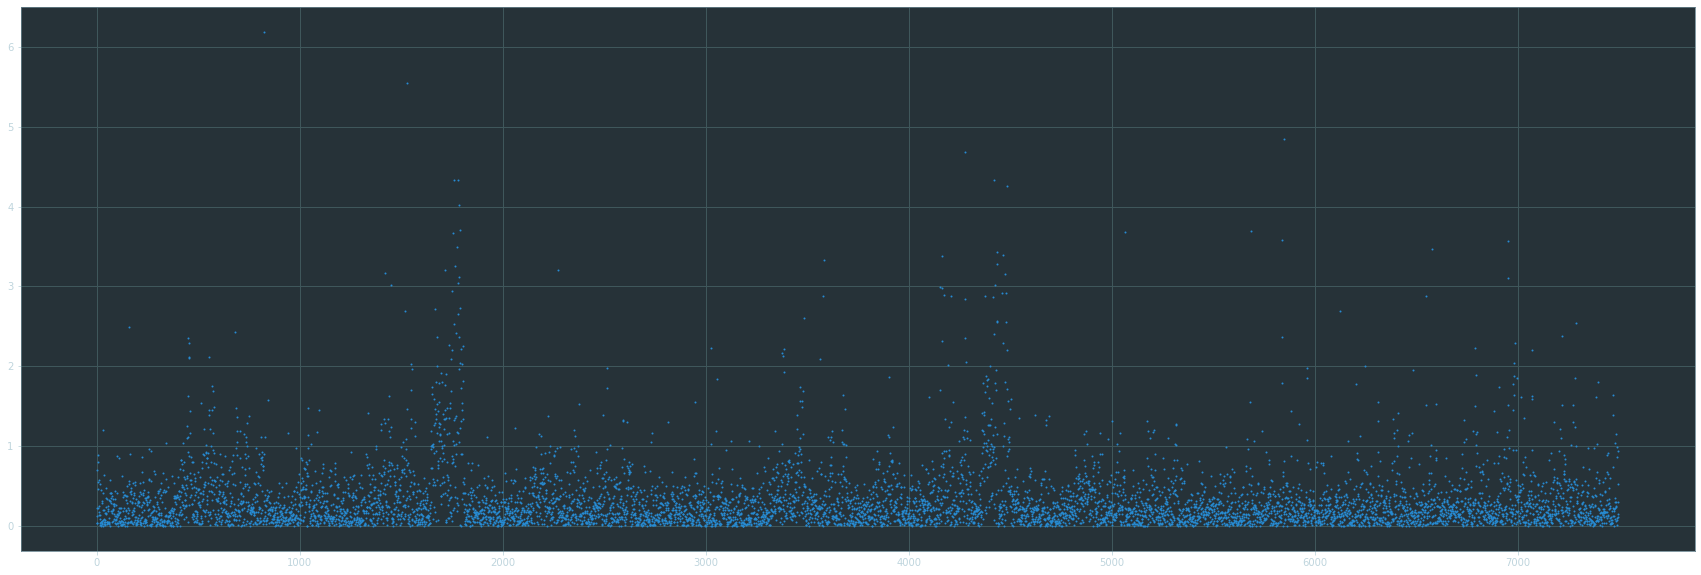

In [150]:
# print(np.median(y), y.std())
plt.figure(figsize=(30, 10))
plt.scatter(range(len(y)), ((y-X.dot(w))**2)**.5, s=1);

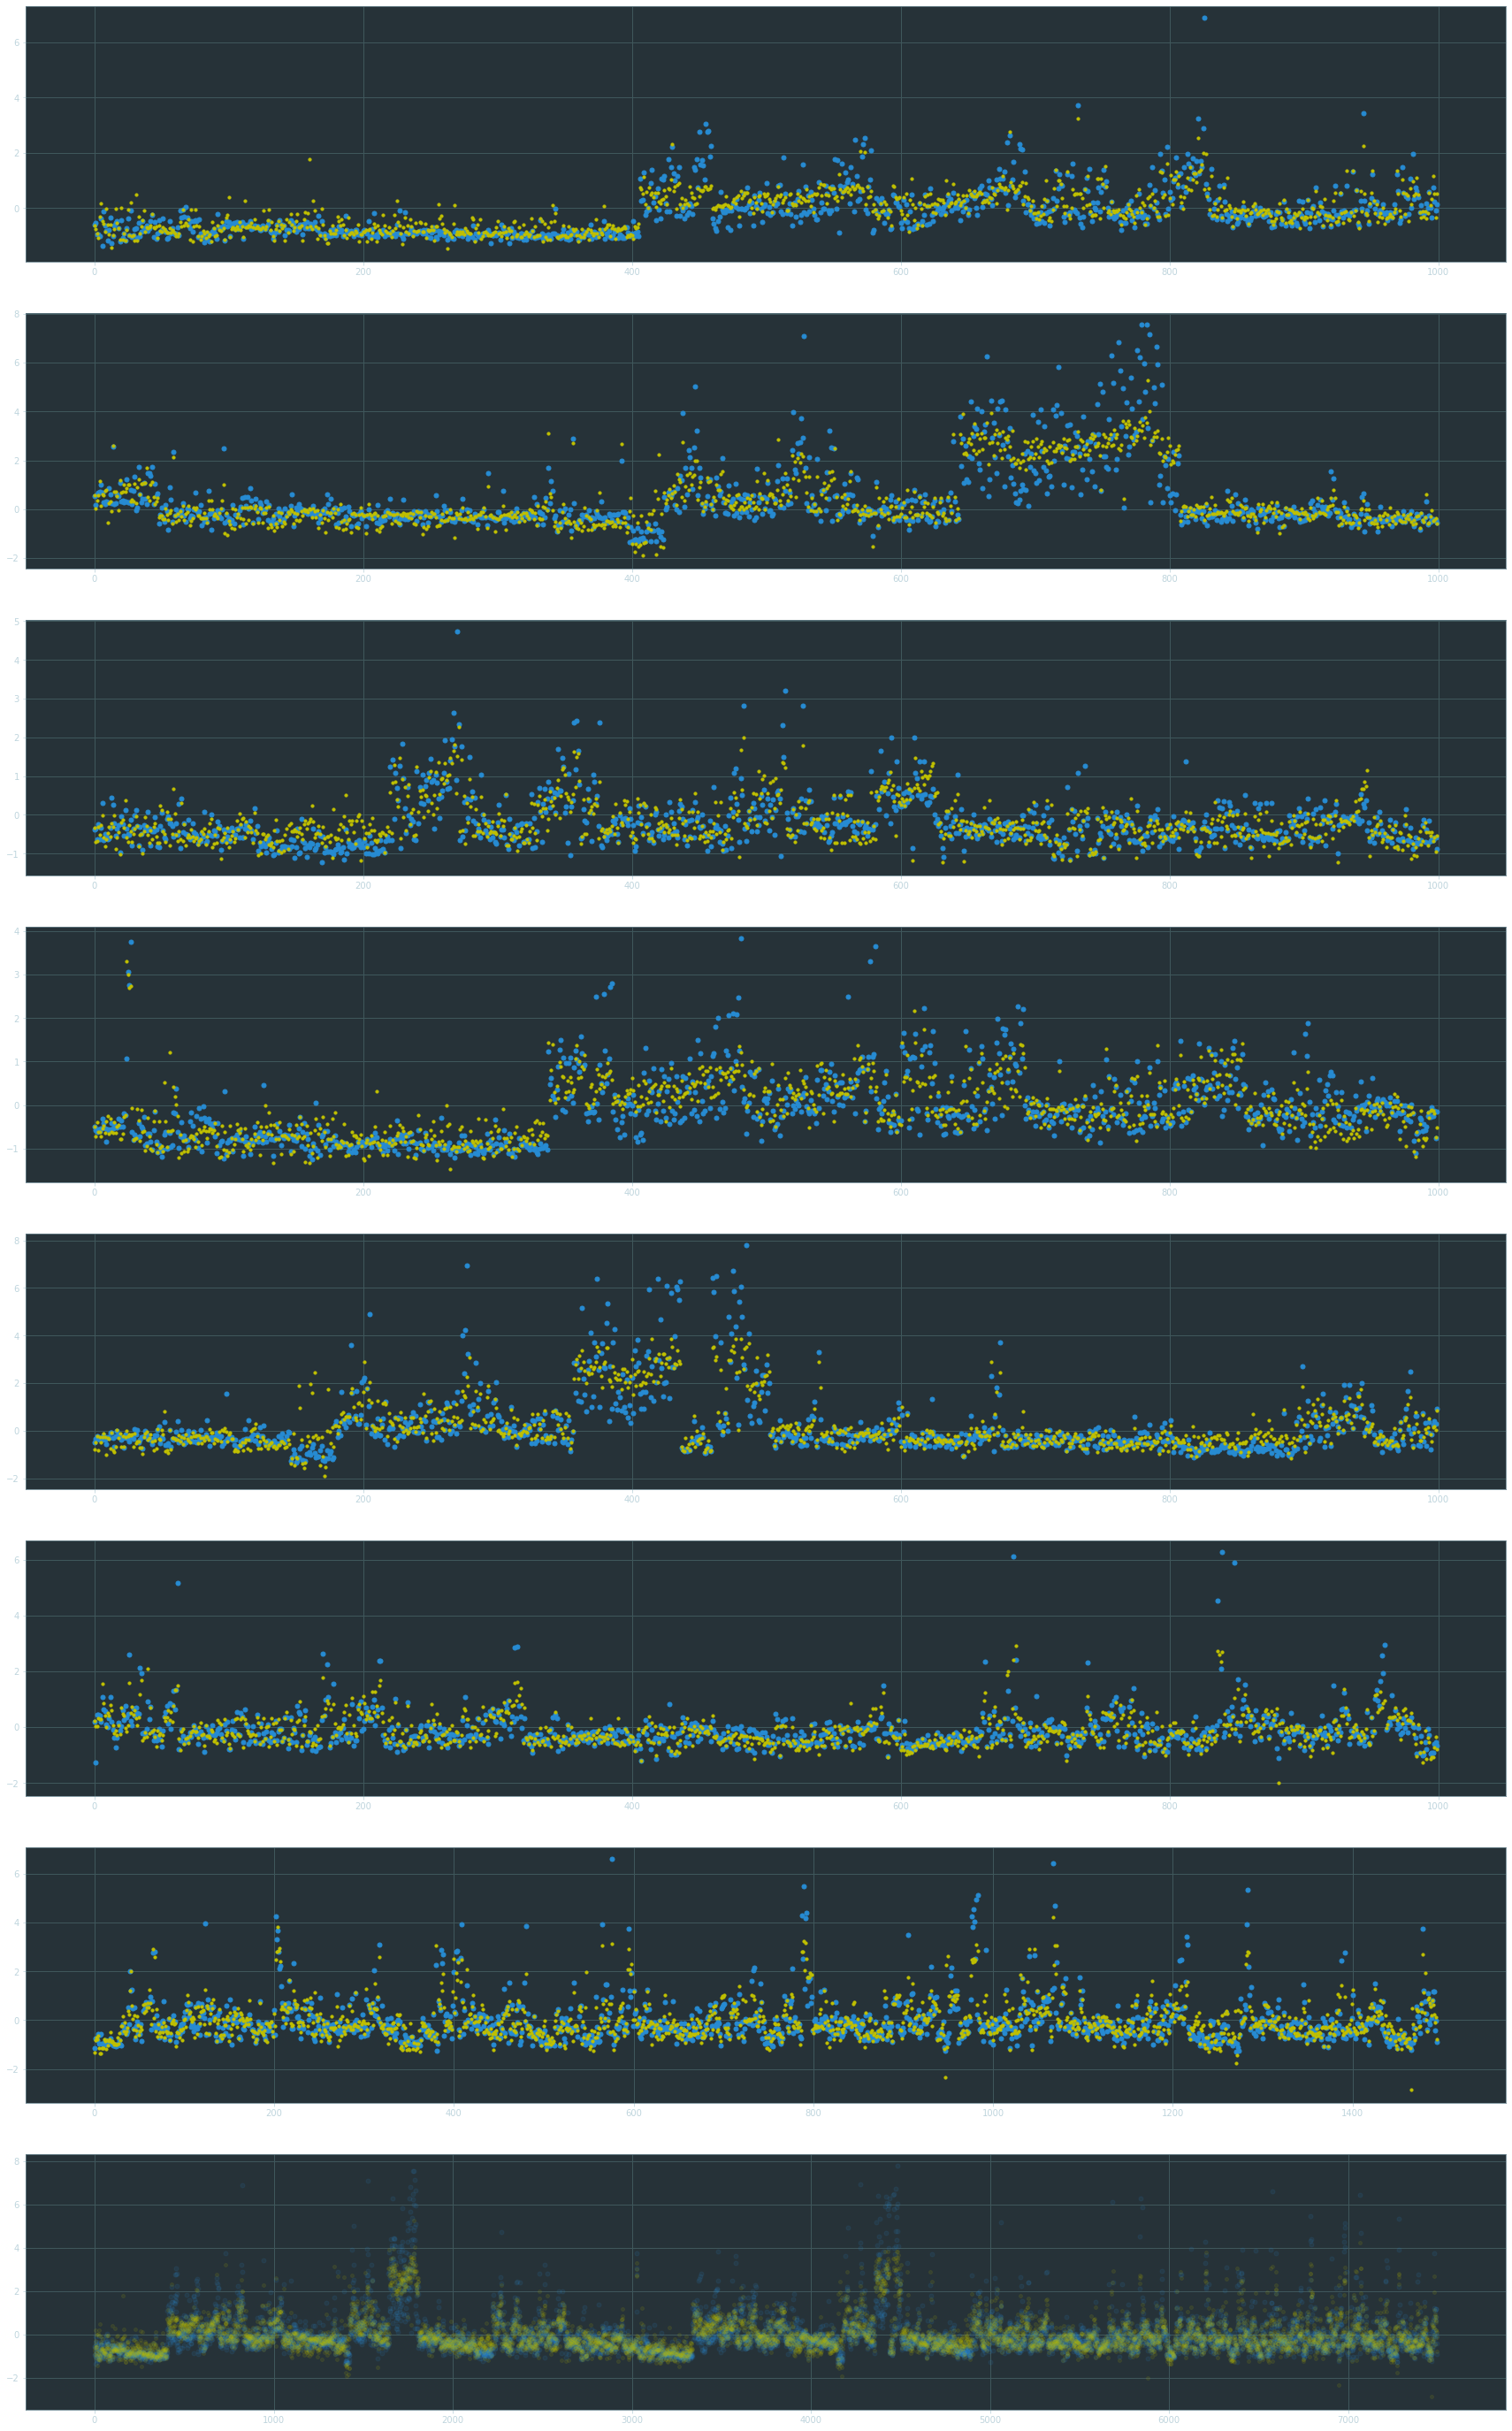

In [130]:
fig, plts = plt.subplots(nrows=8, ncols=1, figsize=(30, 50))

plts[7].scatter(range(len(y)), y, s=25, alpha=.1)
plts[7].scatter(range(len(y)), X.dot(w), s=15, c="y", alpha=.1)
plts[0].scatter(range(1000), y[:1000], s=25)
plts[0].scatter(range(1000), X.dot(w)[:1000], s=10, c="y")
plts[1].scatter(range(1000), y[1000:2000], s=25)
plts[1].scatter(range(1000), X.dot(w)[1000:2000], s=10, c="y")
plts[2].scatter(range(1000), y[2000:3000], s=25)
plts[2].scatter(range(1000), X.dot(w)[2000:3000], s=10, c="y")
plts[3].scatter(range(1000), y[3000:4000], s=25)
plts[3].scatter(range(1000), X.dot(w)[3000:4000], s=10, c="y")
plts[4].scatter(range(1000), y[4000:5000], s=25)
plts[4].scatter(range(1000), X.dot(w)[4000:5000], s=10, c="y")
plts[5].scatter(range(1000), y[5000:6000], s=25)
plts[5].scatter(range(1000), X.dot(w)[5000:6000], s=10, c="y")
plts[6].scatter(range(len(y[6000:])), y[6000:], s=25)
plts[6].scatter(range(len(y[6000:])), X.dot(w)[6000:], s=10, c="y");

In [149]:
sum((X.dot(w)-y)**2)/len(y)

0.29421276061232937